In [1]:
%matplotlib inline 
# %config InlineBackend.figure_format = 'retina'
! echo $OMP_NUM_THREADS

20


In [2]:
import nawrapper as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits

In [3]:
planck_project = '/tigress/zequnl/cmb/software/PSpipe/project/Planck/'

In [4]:
pol_efficiency = {
    '100' : 0.9995,
    '143' : 0.999,
    '217' : 0.999
}

In [5]:
project_dir = '/tigress/zequnl/cmb/data/planck2018/'
map_dir = f'{project_dir}/maps/PR3/frequencyMaps'
mask_dir = f'{project_dir}/maps/PR3/maskMaps/'
beam_dir = f'{project_dir}/BeamWf_HFI_R3.01/'
nside = 2048
lmax = 2508
freq1 = '143'
freq2 = '143'
split1 = '1'
split2 = '2'

# now the specific combination m1 x m2 we want to do here
beam_Wl_hdu = fits.open(beam_dir + f'Wl_R3.01_plikmask_{freq1}hm{split1}x{freq2}hm{split2}.fits')
mfile_1 = f'{map_dir}/HFI_SkyMap_{freq1}_2048_R3.01_halfmission-{1}.fits'
mfile_2 = f'{map_dir}/HFI_SkyMap_{freq2}_2048_R3.01_halfmission-{2}.fits'

maskfile1 = f'{mask_dir}/COM_Mask_Likelihood-temperature-{freq1}-hm{split1}_2048_R3.00.fits'
maskfile2 = f'{mask_dir}/COM_Mask_Likelihood-temperature-{freq2}-hm{split2}_2048_R3.00.fits'
maskfile1_pol = f'{mask_dir}/COM_Mask_Likelihood-polarization-{freq1}-hm{split1}_2048_R3.00.fits'
maskfile2_pol = f'{mask_dir}/COM_Mask_Likelihood-polarization-{freq2}-hm{split2}_2048_R3.00.fits'

In [6]:
pol_fac = pol_efficiency[freq1]
beam_TT = np.sqrt(beam_Wl_hdu[1].data['TT_2_TT'][0])
beam_EE = np.sqrt(beam_Wl_hdu[2].data['EE_2_EE'][0])
beam_BB = np.sqrt(beam_Wl_hdu[3].data['BB_2_BB'][0])
beam_TE = np.sqrt(beam_Wl_hdu[4].data['TE_2_TE'][0])

In [7]:
maps_1 = hp.read_map(mfile_1, field=(0,1,2), verbose=False)
maps_2 = hp.read_map(mfile_2, field=(0,1,2), verbose=False)

mask1 = hp.read_map(maskfile1, verbose=False)
mask2 = hp.read_map(maskfile2, verbose=False)
mask1_pol = hp.read_map(maskfile1_pol, verbose=False)
mask2_pol = hp.read_map(maskfile2_pol, verbose=False)

/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


In [8]:
missing_pixel_1 = (maps_1[0] < -1e30)
missing_pixel_2 = (maps_2[0] < -1e30)

norms = [1,pol_fac,pol_fac]
for i in range(3):
    maps_1[i][missing_pixel_1] = 0.0
    maps_2[i][missing_pixel_2] = 0.0
    maps_1[i] *= 1e6 * norms[i]
    maps_2[i] *= 1e6 * norms[i]
    
maps_1[0] = nw.maptools.sub_mono_di(maps_1[0], mask1, nside)
maps_2[0] = nw.maptools.sub_mono_di(maps_2[0], mask2, nside)

In [9]:
m1 = nw.namap_hp(
    maps=maps_1, masks=(mask1, mask1_pol), 
    beams=(beam_TT, beam_EE), unpixwin=True)
m2 = nw.namap_hp(
    maps=maps_2, masks=(mask2, mask2_pol), 
    beams=(beam_TT, beam_EE), unpixwin=True)

Creating a healpix namap. temperature: True, polarization: True
Including the healpix pixel window function.
Computing spherical harmonics.

Creating a healpix namap. temperature: True, polarization: True
Including the healpix pixel window function.
Computing spherical harmonics.



In [ ]:
bins = nw.create_binning(lmax)

mc_11 = nw.mode_coupling(m1, m1, bins=bins, 
                         mcm_dir='/tigress/zequnl/cmb/data/mcm/planck/143x143_11', overwrite=False)
mc_12 = nw.mode_coupling(m1, m2, bins=bins, 
                         mcm_dir='/tigress/zequnl/cmb/data/mcm/planck/143x143_12', overwrite=False)
mc_22 = nw.mode_coupling(m2, m2, bins=bins, 
                         mcm_dir='/tigress/zequnl/cmb/data/mcm/planck/143x143_22', overwrite=False)

Loading mode-coupling matrices from disk.
Loading mode-coupling matrices from disk.


In [ ]:
Cb = nw.compute_spectra(m1, m2, mc=mc_12)

In [ ]:
plt.plot(Cb['ell'][:1000], Cb['EE'][:1000] * Cb['ell'][:1000]**2)

In [ ]:
Cl11 = nw.compute_spectra(m1, m1, mc=mc_11)
Cl12 = nw.compute_spectra(m1, m2, mc=mc_12)
Cl22 = nw.compute_spectra(m2, m2, mc=mc_22)

In [ ]:
from astropy.io import ascii
th = ascii.read('data/planck/theory_cl.txt')
fg = ascii.read('data/planck/foreground_cl.txt')
fg['BB143X143'] = fg['EE143X143'] * 0.0

In [ ]:
def ap(x): return np.hstack( ((0.0,0.0), x) )
ell_fac = fg['l'][:2507] * (fg['l'][:2507]+1) / (2 * np.pi)
signal_dict = {}
for XY in ['TT', 'TE', 'EE', 'BB']:
    signal_dict[XY] =  ap((th[XY] + fg[XY + '143X143'][:2507])/ell_fac)
    
signal_dict['EB'] = signal_dict['EE'] * 0.0

In [ ]:
pl = nw.planck.PlanckCov(
    ellspath=f'{planck_project}/planck_spectra/vec_all_spectra.dat',
    clpath='data/planck/data_extracted.dat',
    covpath='data/planck/covmat.dat'
    )
# subcov = pl.get_subcov('TT_143x143')

In [ ]:
binleft, binright = np.genfromtxt(
    '/tigress/zequnl/cmb/software/PSpipe/project/Planck/planck_spectra/binused.dat',
    unpack=True, usecols=(0,1), dtype=((int), (int)))

In [ ]:
Cb12 = nw.bin_spec_dict(Cl12, binleft, binright, lmax)
Cb11 = nw.bin_spec_dict(Cl11, binleft, binright, lmax)
Cb22 = nw.bin_spec_dict(Cl22, binleft, binright, lmax)

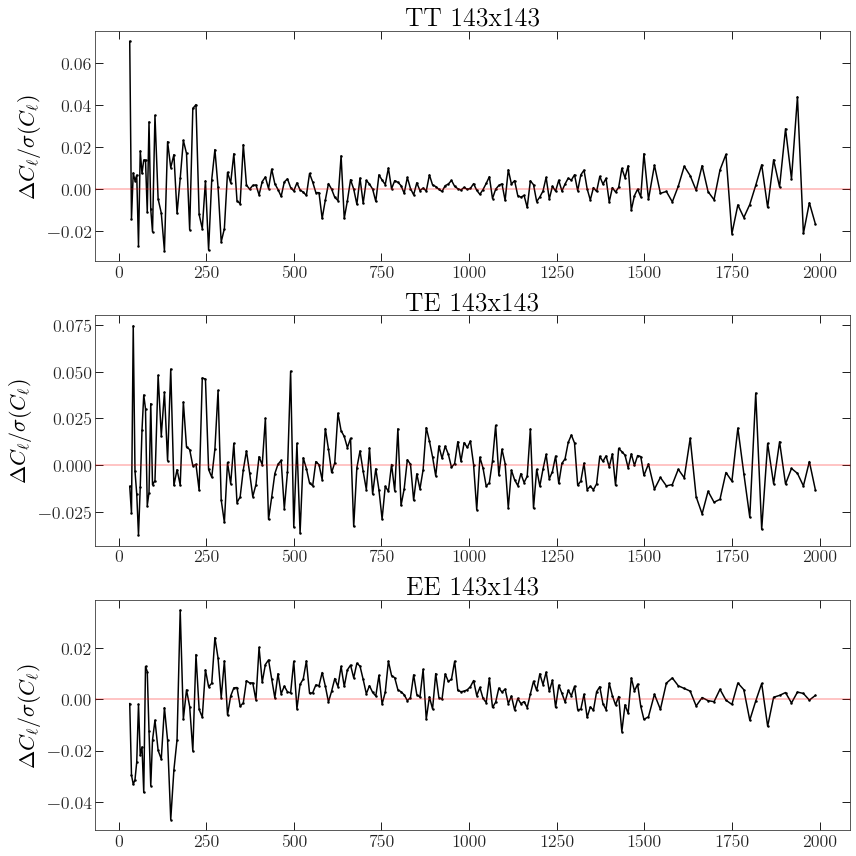

In [29]:
fig, axes = plt.subplots(3,1,figsize=(12,12))
for ax, spec in zip(axes, ['TT', 'TE', 'EE']):
    lb = Cb12['ell']
    
    ell, cl, err, subcov  = pl.get_spec(
        f'{spec}_{freq1}x{freq2}')
    dl_ref_fac = ell*(ell+1)/(2*np.pi)
    ref_filt = np.in1d(lb, ell)
    if spec == 'TE':
        diy_spec = (Cb12['TE'][ref_filt] + Cb12['ET'][ref_filt])/ 2.0
    else:
        diy_spec = Cb12[spec][ref_filt]
    
    ax.plot(ell, (diy_spec - (cl)) / (err), 'k.-', label=spec)
    ax.axhline(0, color='red', alpha=0.3)
    ax.set_ylabel(r'$\Delta C_{\ell} / \sigma(C_{\ell})$')
    ax.set_title(f'{spec} {freq1}x{freq2}')
    
plt.tight_layout()

# Testing the Sims

In [ ]:
# TT_list = []

# sim_max = 306
# for i in range(0, sim_max+1):
#     Cl_i = dict(np.load(f'/scratch/gpfs/zequnl/plancksims/Cl_{i}.npz'))
#     TT_list.append(
#         nw.bin_spec_dict(Cl_i, binleft, binright, lmax)['TT']
#     )

In [ ]:
# ell_sub_list = [np.arange(l, r) for (l, r) in zip(binleft, binright+1)]
# n_ell = len(bins.get_effective_ells())
# ell_cov, cl, err, cov_plic = pl.get_spec('TT_143x143')
# binned_cov = np.zeros((len(ell_sub_list), len(ell_sub_list)))
# lb = np.array([ (l+r)/2.0 for l,r in zip(binleft, binright) ])
# for i, (bin_i) in enumerate( zip(binleft, binright+1) ):
#     for j, (bin_j) in enumerate( zip(binleft, binright+1) ):
#         binned_cov[i,j] = np.mean( cov.covmat['TTTT'][bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]] )

# plt.plot( ell_cov, np.sqrt(np.diag(cov_plic)) * ell_cov**2, label="extracted plic cov" )

# plt.plot(lb[lb < ell_cov[-1]], 
#          (np.sqrt(np.diag(binned_cov)) * lb**2)[lb < ell_cov[-1]], label='analytic')

# plt.legend()

# plt.plot(Cb12['ell'],np.std(TT_list, axis=0) * Cb12['ell']**2  )

# plt.figure()

# ratio = np.sqrt(np.diag(binned_cov)) / np.std(TT_list, axis=0)
# plt.plot(Cb12['ell'], savgol_filter(ratio, 11, 2))
# plt.ylim(0.0, 1.2)

# Computing the Point Source Correction

The general plan will be to generate realizations of the total theory spectrum, and compute the noise power spectrum from the difference in half-missions.

### Computing the Noise Power Spectrum

In [ ]:
hm_diff = nw.namap_hp(
    maps=[maps_1[i] - maps_2[i] for i in range(3)], 
    masks=(np.minimum(mask1, mask2), np.minimum(mask1_pol, mask2_pol)), 
    beams=(beam_TT, beam_EE), 
    unpixwin=True)

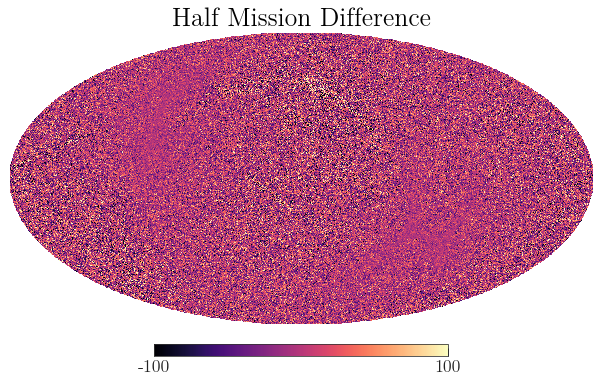

In [34]:
hp.mollview(hm_diff.map_I, min=-100, max=100, title='Half Mission Difference')

In [ ]:
Cb_noise = nw.compute_spectra(hm_diff, hm_diff, mc=mc_12)

In [ ]:
from scipy.signal import savgol_filter

In [ ]:
lognoiseTT = np.log(Cb_noise['TT'])
smoothedTT = np.exp(savgol_filter(lognoiseTT, 101, 3))

lognoiseEE = np.log(Cb_noise['EE'])
smoothedEE = np.exp(savgol_filter(lognoiseEE, 101, 3))

(0.0, 1500)

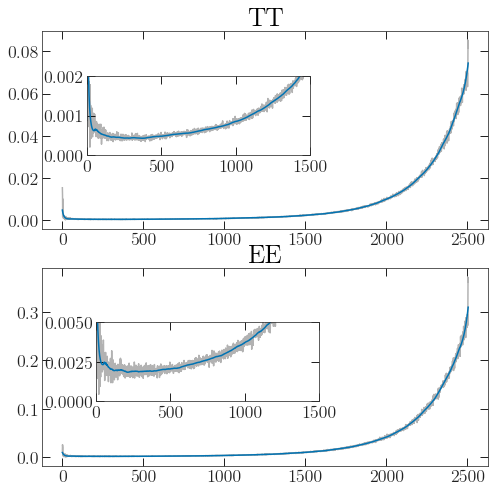

In [35]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(2, 1, figsize=(8,8))
axes[0].set_title('TT')
axes[0].plot(Cb_noise['TT'],'-', alpha=0.3)
axes[0].plot(smoothedTT,'-')

axins = inset_axes(axes[0], width="50%", height="40%", loc='upper left', borderpad=2.5)
axins.plot(Cb_noise['TT'],'-', alpha=0.3)
axins.plot(smoothedTT,'-')
axins.set_ylim(0.0, 0.002)
axins.set_xlim(0.0, 1500)

axes[1].set_title('EE')

axes[1].plot(Cb_noise['EE'],'-', alpha=0.3)
axes[1].plot(smoothedEE,'-')

axins = inset_axes(axes[1], width="50%", height="40%", loc='upper left', borderpad=3)
axins.plot(Cb_noise['EE'],'-', alpha=0.3)
axins.plot(smoothedEE,'-')
axins.set_ylim(0.0, 0.005)
axins.set_xlim(0.0, 1500)

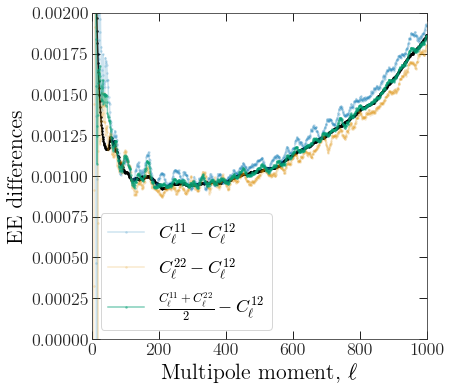

In [36]:
plt.figure(figsize=(6,6), facecolor='white')
plt.plot(smoothedEE / 2)
plt.plot( savgol_filter(Cl11['EE'] - Cl12['EE'], 31, 2), alpha=0.2, label='$C_{\ell}^{11} - C_{\ell}^{12}$')
plt.plot( savgol_filter(Cl22['EE'] - Cl12['EE'], 31, 2), alpha=0.2, label='$C_{\ell}^{22} - C_{\ell}^{12}$')
plt.plot( savgol_filter((Cl11['EE'] + Cl22['EE'])/2 - Cl12['EE'], 31, 2), alpha=0.5, label=r'$\frac{C_{\ell}^{11} + C_{\ell}^{22}}{2} - C_{\ell}^{12}$')
plt.ylim(0.0000, 0.002)
plt.xlim(0,1000)
plt.ylabel(r'EE differences')
plt.xlabel(r'Multipole moment, $\ell$')
plt.legend()

In [37]:
def get_maps():
    # apply the pixel window transfer function (pixwin=True)
    #TT, EE, BB, TE, EB, TB
    #I've set EB and TB = 0
    num_ell = len(smoothedTT) + 2
    
    m = hp.synfast(
        (signal_dict['TT'] * beam_TT[:num_ell]**2, 
         signal_dict['EE'] * beam_EE[:num_ell]**2, 
         signal_dict['BB'] * beam_EE[:num_ell]**2, 
         signal_dict['TE'] * (beam_TT * beam_EE)[:num_ell]), 
        nside, verbose=False, pixwin=True, new=True)
    
    # BB noise is set to same as EE noise
    n1 = hp.synfast(
        (ap(smoothedTT / 2) * beam_TT[:num_ell]**2, 
         ap(smoothedEE / 2) * beam_EE[:num_ell]**2, 
         ap(smoothedEE / 2) * beam_EE[:num_ell]**2, 
         np.zeros(num_ell), np.zeros(num_ell), np.zeros(num_ell)), 
        nside, verbose=False, pixwin=True, new=True)
    n2 = hp.synfast(
        (ap(smoothedTT / 2) * beam_TT[:num_ell]**2, 
         ap(smoothedEE / 2) * beam_EE[:num_ell]**2, 
         ap(smoothedEE / 2) * beam_EE[:num_ell]**2, 
         np.zeros(num_ell), np.zeros(num_ell), np.zeros(num_ell)), 
        nside, verbose=False, pixwin=True, new=True)
    
    # smooth the maps with the beam we made up earlier
#     m1_data = hp.smoothing(m + n1, beam_window=B_ell, verbose=False)
#     m2_data = hp.smoothing(m + n2, beam_window=B_ell, verbose=False)
    
    # Make the namap!
    m1 = nw.namap_hp(maps=(m + n1), masks=(mask1, mask1_pol),
                  beams=(beam_TT, beam_EE), verbose=False, unpixwin=True)
    m2 = nw.namap_hp(maps=(m + n2), masks=(mask2, mask2_pol),
                  beams=(beam_TT, beam_EE), verbose=False, unpixwin=True)
    return m1, m2

In [38]:
from tqdm import tqdm
start_i = 0
getattr(tqdm, '_instances', {}).clear()  # ⬅ add this line
list(tqdm(range(start_i, start_i + 500)))

100%|██████████| 500/500 [00:00<00:00, 1036142.29it/s]

done!


In [ ]:
for i in tqdm(range(start_i, start_i + 500)):
    m1_e, m2_e = get_maps()
    Cl12_e = nw.compute_spectra(m1_e, m2_e, mc=mc_12)
#     Cb12_e = nw.bin_spec_dict(Cl12_e, binleft, binright, lmax)
    
    np.savez(f'/scratch/gpfs/zequnl/plancksims/Cl_{i}.npz', **Cl12_e)

 17%|█▋        | 86/500 [2:35:13<12:34:13, 109.31s/it]

In [69]:
m1_e, m2_e = get_maps()

In [77]:
Cl12_e = nw.compute_spectra(m1_e, m2_e, mc=mc_12)
Cb12_e = nw.bin_spec_dict(Cl12_e, binleft, binright, lmax)

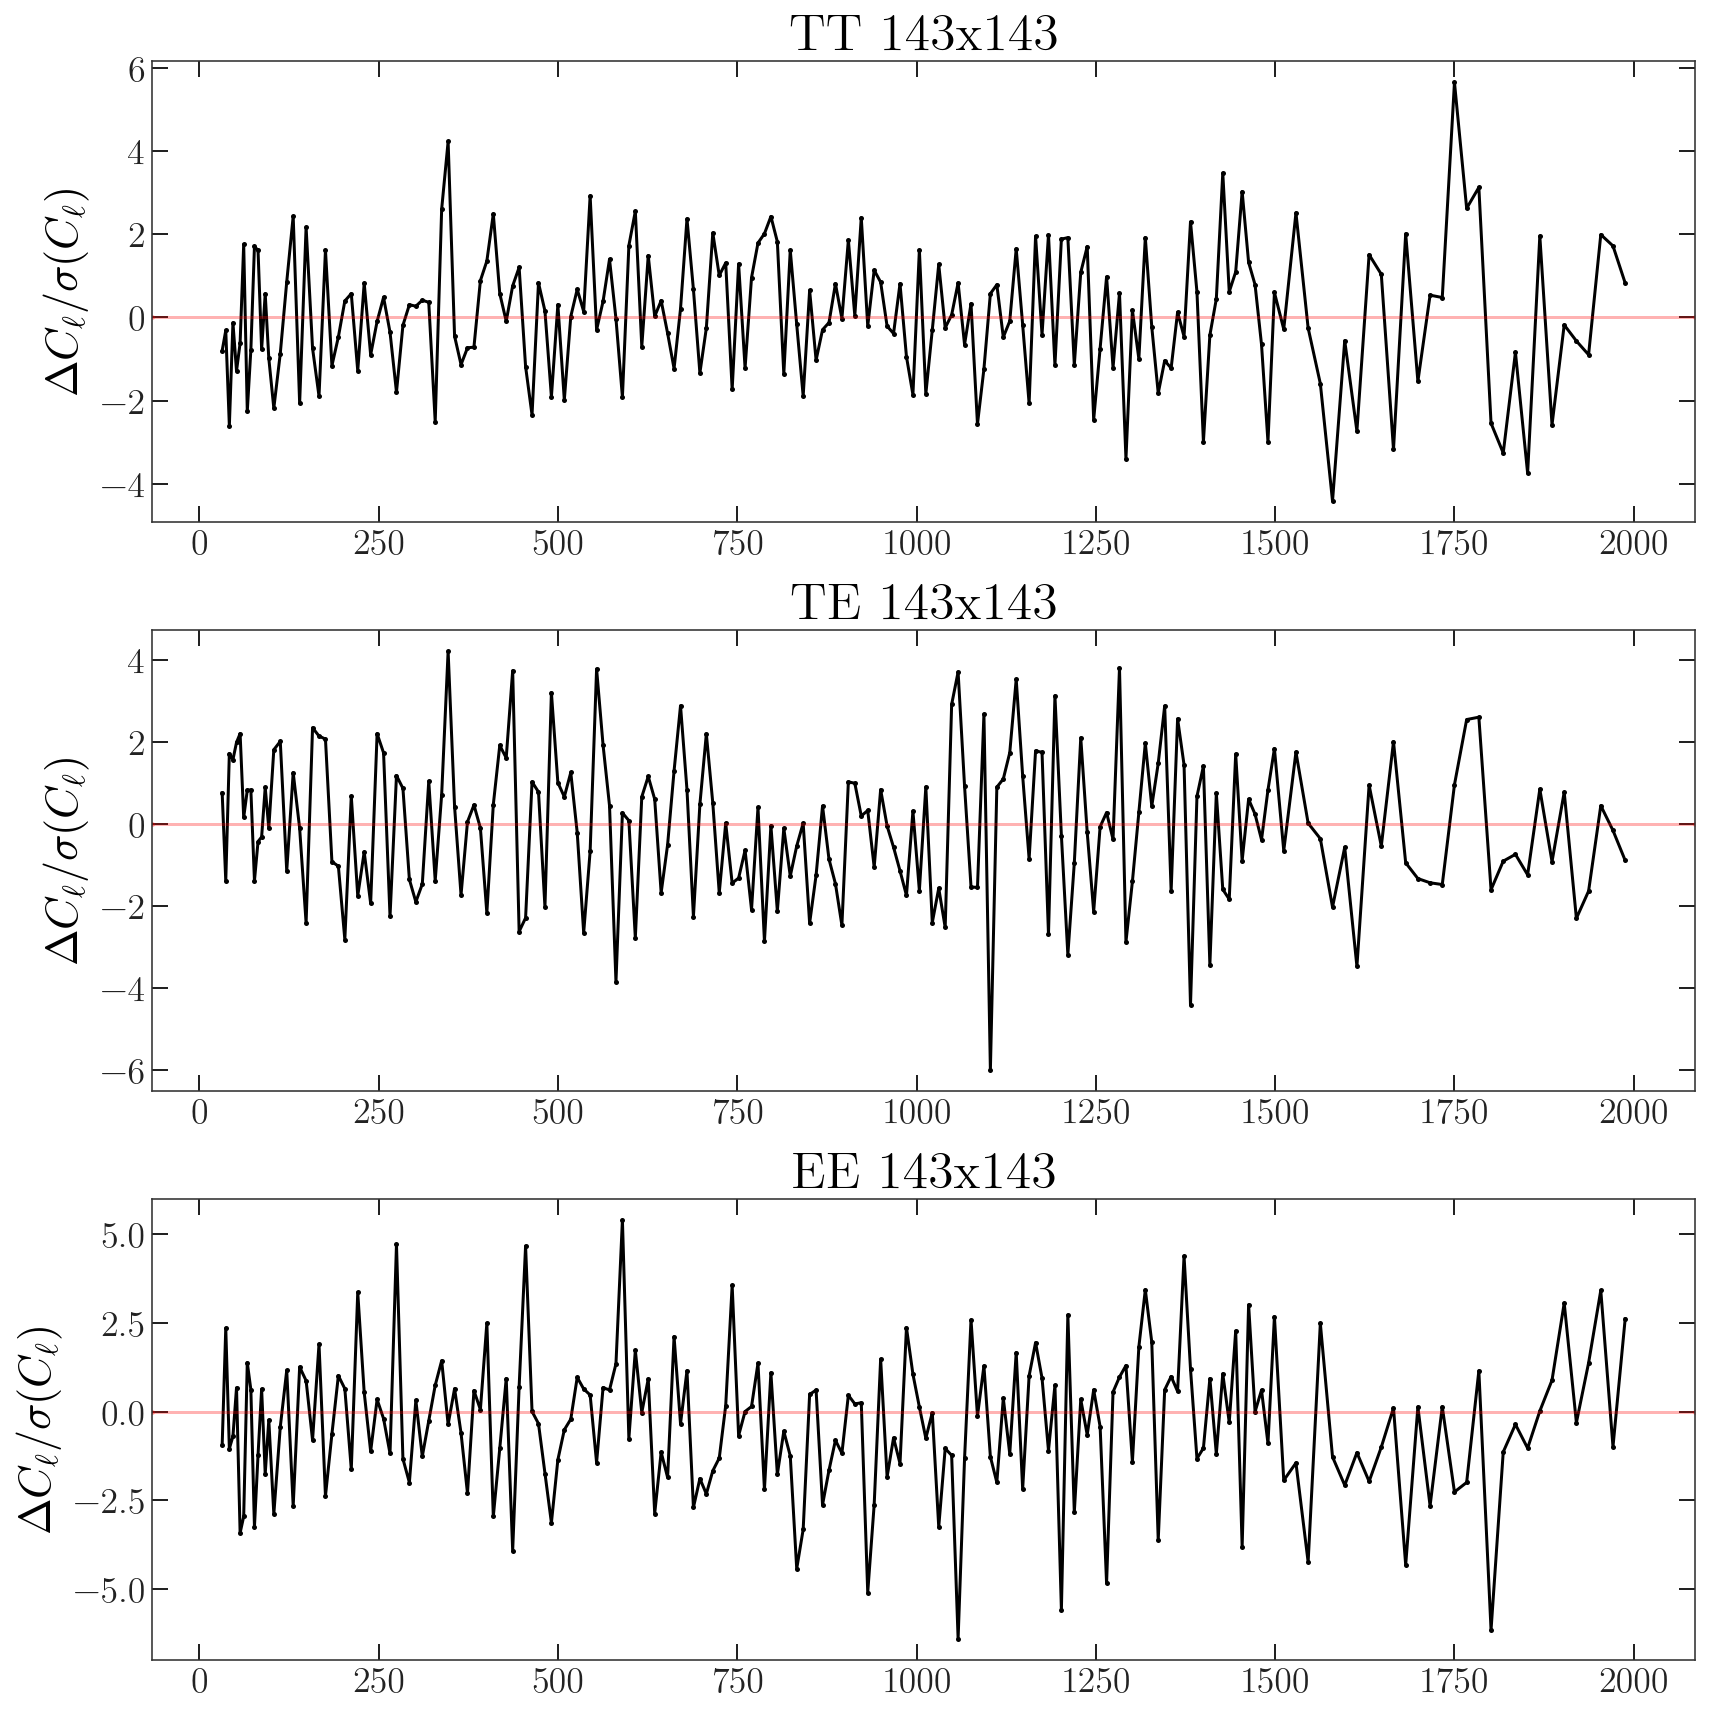

In [79]:
fig, axes = plt.subplots(3,1,figsize=(12,12))
for ax, spec in zip(axes, ['TT', 'TE', 'EE']):
    lb = Cb12['ell']
    
    ell, cl, err, subcov  = pl.get_spec(
        f'{spec}_{freq1}x{freq2}')
    dl_ref_fac = ell*(ell+1)/(2*np.pi)
    ref_filt = np.in1d(lb, ell)
    if spec == 'TE':
        diy_spec = (Cb12_e['TE'][ref_filt] + Cb12_e['ET'][ref_filt])/ 2.0
    else:
        diy_spec = Cb12_e[spec][ref_filt]
    
#     ax.plot(ell, ((cl)) * ell**2 , 'k.-', label=spec)
#     ax.plot(ell, (diy_spec) * ell**2, 'r.-', label=spec)

    ax.plot(ell, (diy_spec - (cl)) / (err), 'k.-', label=spec)

    ax.axhline(0, color='red', alpha=0.3)
    ax.set_ylabel(r'$\Delta C_{\ell} / \sigma(C_{\ell})$')
    ax.set_title(f'{spec} {freq1}x{freq2}')
    
plt.tight_layout()

# Compare

In [27]:
pl = nw.planck.PlanckCov(
    ellspath=f'{planck_project}/planck_spectra/vec_all_spectra.dat',
    clpath='data/planck/data_extracted.dat',
    covpath='data/planck/covmat.dat'
    )
ell, cl, err, subcov  = pl.get_spec('TT_143x143')

In [96]:
def ap(x): return np.hstack( ((0.0,0.0), x) )

noise_dict = {'T1T1' : ap(smoothedTT) / 2, 'T2T2': ap(smoothedTT) / 2,
              'E1E1' : ap(smoothedEE) / 2, 'E2E2': ap(smoothedEE) / 2}
# for k in signal_dict:
#     if 'B' in k:
#         signal_dict[k] *= 0.0
#         noise_dict[k] = signal_dict[k]

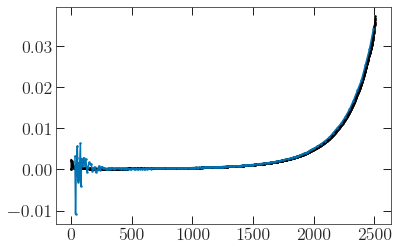

In [107]:
plt.plot(noise_dict['T1T1'])
plt.plot(Cb11['ell'], Cb11['TT'] - Cb12['TT'])
# plt.yscale('log')

In [98]:
np.savez(f'data/planck_{freq1}x{freq2}_noise.npz', **noise_dict)

In [99]:
dict(np.load('data/planck_143_noise.npz'))

{'T1T1': array([0.        , 0.        , 0.00483622, ..., 0.07310347, 0.07374609,
        0.07440875]),
 'T2T2': array([0.        , 0.        , 0.00483622, ..., 0.07310347, 0.07374609,
        0.07440875]),
 'E1E1': array([0.        , 0.        , 0.00970937, ..., 0.30361282, 0.30661478,
        0.30971289]),
 'E2E2': array([0.        , 0.        , 0.00970937, ..., 0.30361282, 0.30661478,
        0.30971289])}

In [100]:
cov = nw.nacov(m1, m2, mc_11=mc_11, mc_12=mc_12, mc_22=mc_22,  
               signal=signal_dict, noise=noise_dict, 
               smoothing_window=1, smoothing_polyorder=0)

In [101]:
%%time
cov.compute()

CPU times: user 11h 33min, sys: 4min 1s, total: 11h 37min 2s
Wall time: 35min


Text(0.5, 0, 'Multipole, $\\ell$')

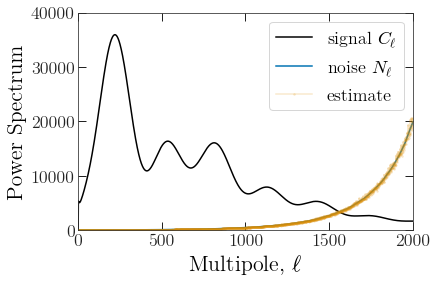

In [102]:
plt.figure(figsize=(6,4))
plt.plot(cov.signal['TT'] * np.arange(2509)**2, '-', label="signal $C_{\ell}$")
plt.plot(cov.noise['T1T1'] * np.arange(2509)**2, '-', label="noise $N_{\ell}$")
plt.plot((Cb_noise['TT'] / 2)* np.arange(2,2509)**2, alpha=0.2, label='estimate')
# plt.yscale('log')
plt.xlim(0,2000)
plt.ylim(0,40000)
plt.legend()
plt.ylabel(r'Power Spectrum')
plt.xlabel(r'Multipole, $\ell$')

In [34]:
n_ell = len(bins.get_effective_ells())
ell_cov, cl, err, cov_plic = pl.get_spec('TT_143x143')

Text(0.5, 0, 'Multipole $\\ell$')

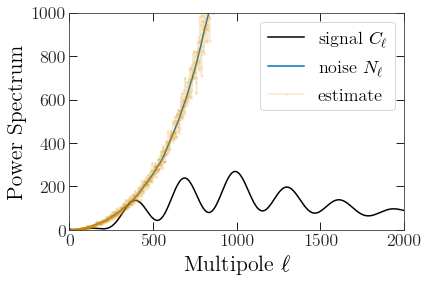

In [109]:
plt.figure(figsize=(6,4))
plt.plot(cov.signal['EE'] * np.arange(2509)**2, '-', label="signal $C_{\ell}$")
plt.plot(cov.noise['E1E1'] * np.arange(2509)**2, '-', label="noise $N_{\ell}$")
plt.plot((Cb_noise['EE'] / 2)* np.arange(2,2509)**2, alpha=0.2, label='estimate')
# plt.yscale('log')
plt.xlim(0,2000)
plt.ylim(0,1000)
plt.legend()
plt.ylabel(r'Power Spectrum')
plt.xlabel(r'Multipole $\ell$')

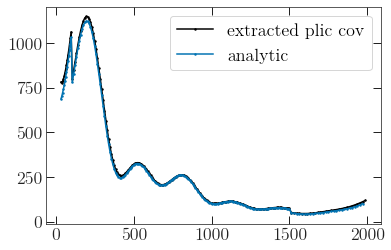

In [110]:
n_ell = len(bins.get_effective_ells())
ell_cov, cl, err, cov_plic = pl.get_spec('TT_143x143')
ell_sub_list = [np.arange(l, r) for (l, r) in zip(binleft, binright+1)]

binned_cov = np.zeros((len(ell_sub_list), len(ell_sub_list)))
lb = np.array([ (l+r)/2.0 for l,r in zip(binleft, binright) ])
for i, (bin_i) in enumerate( zip(binleft, binright+1) ):
    for j, (bin_j) in enumerate( zip(binleft, binright+1) ):
        binned_cov[i,j] = np.mean( cov.covmat['TTTT'][bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]] )

plt.plot( ell_cov, np.sqrt(np.diag(cov_plic)) * ell_cov**2, label="extracted plic cov" )

plt.plot(lb[lb < ell_cov[-1]], 
         (np.sqrt(np.diag(binned_cov)) * lb**2)[lb < ell_cov[-1]], label='analytic')

plt.legend()

plt.figure()
plt.plot( np.sqrt(np.diag(cov_plic)) / (np.sqrt(np.diag(binned_cov)))[:-16] )

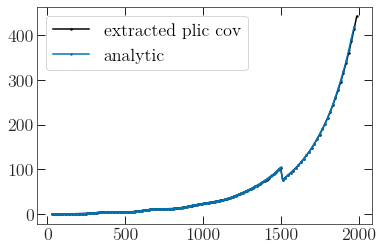

In [103]:
ell_sub_list = [np.arange(l, r) for (l, r) in zip(binleft, binright+1)]
n_ell = len(bins.get_effective_ells())
ell_cov, cl, err, cov_plic = pl.get_spec('EE_143x143')

cov_array = cov.covmat['EEEE']
weight_array = np.ones_like(cov_array)

for i1, l1 in enumerate(cov.lb):
    for i2, l2 in enumerate(cov.lb):
        weight_array[i1, i2] = (l1 * (l1 + 1)) * (l2 * (l2 + 1))

binned_cov = np.zeros((len(ell_sub_list), len(ell_sub_list)))
lb = np.array([ (l+r)/2.0 for l,r in zip(binleft, binright) ])
for i, (bin_i) in enumerate( zip(binleft, binright+1) ):
    for j, (bin_j) in enumerate( zip(binleft, binright+1) ):
        binned_cov[i,j] = (
            np.sum( 
                (weight_array[bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]] * 
                 cov_array[bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]]) ) / 
            np.sum( (weight_array)[bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]] )
        )

plt.plot( ell_cov, np.sqrt(np.diag(cov_plic)) * ell_cov**2, label="extracted plic cov" )

plt.plot(lb[lb < ell_cov[-1]], 
         (np.sqrt(np.diag(binned_cov)) * lb**2)[lb < ell_cov[-1]], label='analytic')

plt.legend()

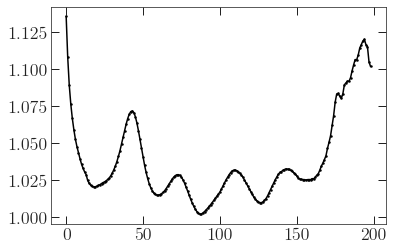

In [111]:
plt.plot( np.sqrt(np.diag(cov_plic)) / (np.sqrt(np.diag(binned_cov)))[:-16] )

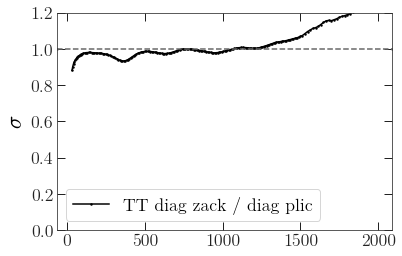

In [38]:
# plt.plot( l,  np.diag(binned_cov)[:199] / (np.diag(cov_plic)) / pixwin_T[l.astype(int)]**4 )
plt.plot( ell_cov, np.sqrt( np.diag(binned_cov)[:199] / np.diag(cov_plic) ), label='TT diag zack / diag plic' )
# plt.plot( ell_cov, np.sqrt( np.diag(binned_cov)[:199] / np.diag(cov_plic) / m1.pixwin_T[ell_cov.astype(int)]**2 ), label='TT diag zack / diag plic' )
plt.legend()
# plt.plot( l,  np.diag(binned_cov)[:199] / (np.diag(cov_plic)) * pixwin_T[l.astype(int)]**4 )
plt.ylim(0.0, 1.2)
plt.ylabel(r'$\sigma$')
plt.gca().axhline(1.0,ls='--')

In [112]:
import pickle as pkl

Cb_list = pkl.load(open( "/tigress/zequnl/cmb/data/planck2018/FFP10_sims.p", "rb" ))

In [113]:
ell = Cb_list[0]['ell'][:199]

In [114]:
import random

In [115]:
std_diag = np.std([Cb['TT'] for Cb in Cb_list], axis=0)[:199]
mean_diag = np.mean([Cb['TT'] for Cb in Cb_list], axis=0)[:199]
                   
def get_bootstrap():
    return np.std([Cb['TT'] for Cb in 
                    random.choices(Cb_list, k=100)], 
                   axis=0)

In [116]:
B = 500
bootstrap_samps = [get_bootstrap()[:199] for i in range(B)]

In [117]:
error_bar_on_error_bar = np.sqrt(
    np.sum(
        (np.array([samp / np.sqrt(np.diag(binned_cov)[:199]) for samp in bootstrap_samps])
        - std_diag / np.sqrt(np.diag(binned_cov)[:199]))**2
        / (B-1), axis=0
    )
)

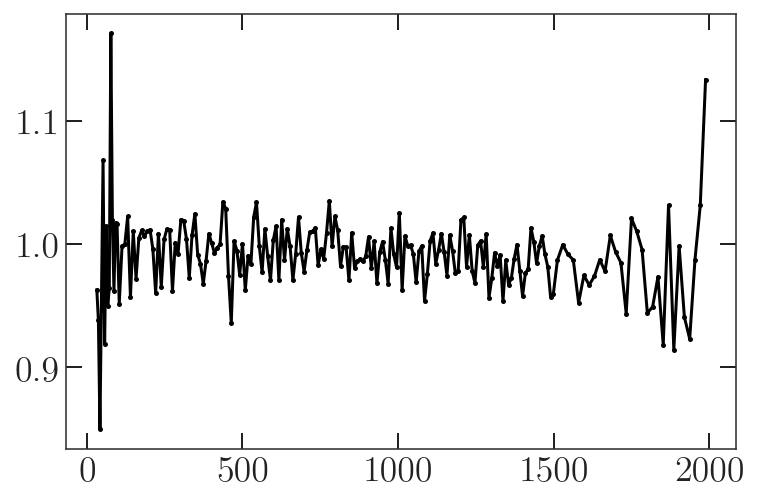

In [119]:
plt.plot(ell[:199],(mean_diag/ Cb12['TT'][:199])[:199])

In [109]:
gp_spec = get_gp(ell[:199], (Cb12['TT'][:199] / mean_diag)[:199] ,
                 alpha=error_bar_on_error_bar[:199]**2)
gp_spec_tt = gp_spec.predict(np.atleast_2d(ell).T)
# gp_spec_tt = Cb12['TT'] / mean_diag

NameError: name 'get_gp' is not defined

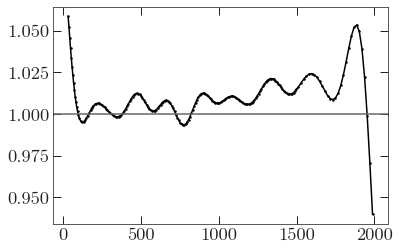

In [63]:
plt.plot(ell, gp_spec_tt)
plt.axhline(1.0)

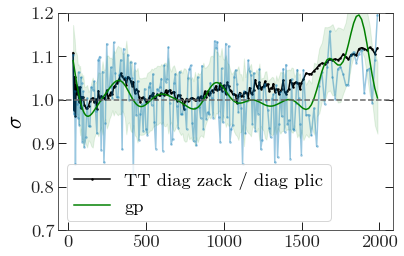

In [64]:
# plt.plot( l,  np.diag(binned_cov)[:199] / (np.diag(cov_plic)) / pixwin_T[l.astype(int)]**4 )
# plt.plot( ell, np.sqrt( np.diag(binned_cov)) / sims_diag, label='TT diag zack / diag plic' )


plt.plot( ell_cov, 
         np.sqrt(np.diag(cov_plic) /  np.diag(binned_cov)[:199]), 
         label='TT diag zack / diag plic' )

plt.plot(ell[:199], 
         (std_diag / np.sqrt(np.diag(binned_cov)[:199]))[:199], alpha=0.4)

gp_fit = get_gp(ell, std_diag / np.sqrt(np.diag(binned_cov)[:199]) 
                * gp_spec_tt**2, 
               alpha=(error_bar_on_error_bar)**2)
gp_pred = gp_fit.predict(np.atleast_2d(ell).T)
plt.plot( ell[:199], gp_pred[:199], "g-", label='gp' )

plt.fill_between(ell[:199], 
                 (gp_pred - error_bar_on_error_bar)[:199],
                 (gp_pred + error_bar_on_error_bar)[:199],
                 color="g",
                alpha=0.1)

plt.legend(loc='lower left')
# plt.plot( l,  np.diag(binned_cov)[:199] / (np.diag(cov_plic)) * pixwin_T[l.astype(int)]**4 )
plt.ylim(0.7, 1.2)
plt.ylabel(r'$\sigma$')
plt.gca().axhline(1.0,ls='--')

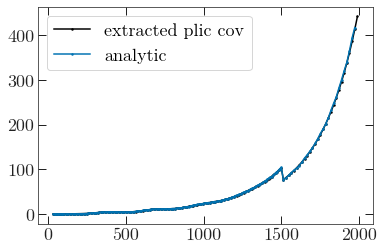

In [35]:
ell_sub_list = [np.arange(l, r) for (l, r) in zip(binleft, binright+1)]

cov_array = cov.covmat['EEEE']
weight_array = np.ones_like(cov_array)

for i1, l1 in enumerate(cov.lb):
    for i2, l2 in enumerate(cov.lb):
        weight_array[i1, i2] = (l1 * (l1 + 1)) * (l2 * (l2 + 1))

binned_cov = np.zeros((len(ell_sub_list), len(ell_sub_list)))
lb = np.array([ (l+r)/2.0 for l,r in zip(binleft, binright) ])
for i, (bin_i) in enumerate( zip(binleft, binright+1) ):
    for j, (bin_j) in enumerate( zip(binleft, binright+1) ):
        binned_cov[i,j] = (
            np.sum( 
                (weight_array[bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]] * 
                 cov_array[bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]]) ) / 
            np.sum( (weight_array)[bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]] )
        )

plt.plot( ell_cov, np.sqrt(np.diag(cov_plic)) * ell_cov**2, label="extracted plic cov" )

plt.plot(lb[lb < ell_cov[-1]], 
         (np.sqrt(np.diag(binned_cov)) * lb**2)[lb < ell_cov[-1]], label='analytic')

plt.legend()

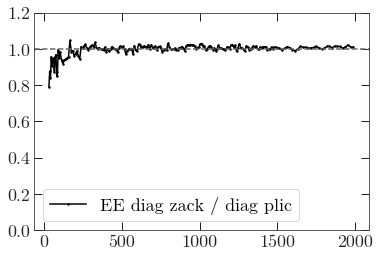

In [36]:
# plt.plot( l,  np.diag(binned_cov)[:199] / (np.diag(cov_plic)) / pixwin_T[l.astype(int)]**4 )
plt.plot( ell_cov, np.sqrt(np.diag(binned_cov)[:199] / np.diag(cov_plic) ), label='EE diag zack / diag plic' )
# plt.plot( 1/m1.pixwin_P)
plt.legend()
# plt.plot( l,  np.diag(binned_cov)[:199] / (np.diag(cov_plic)) * pixwin_T[l.astype(int)]**4 )
plt.ylim(0.0, 1.2)
plt.gca().axhline(1.0,ls='--')

In [ ]:
# covar_22_22 = nmt.gaussian_covariance(
#             cov.cw, 2, 2, 2, 2,  # Spins of the 4 fields
#             [cov.signal['EE']+cov.noise['EE'], 0.0 * cov.signal['EB'],
#              0.0 * cov.signal['EB'], 0.0 * cov.signal['BB']],  # EE, EB, BE, BB
#             [cov.signal['EE'], 0.0 * cov.signal['EB'],
#              0.0 * cov.signal['EB'], 0.0 * cov.signal['BB']],  # EE, EB, BE, BB
#             [cov.signal['EE'], 0.0 * cov.signal['EB'],
#              0.0 * cov.signal['EB'], 0.0 * cov.signal['BB']],  # EE, EB, BE, BB
#             [cov.signal['EE']+cov.noise['EE'], 0.0 * cov.signal['EB'],
#              0.0 * cov.signal['EB'], 0.0 * cov.signal['BB']],  # EE, EB, BE, BB
#             cov.mc.w22, wb=cov.mc.w22).reshape([cov.num_ell, 4,
#                                   cov.num_ell, 4])

In [ ]:
# plt.figure(figsize=(6,4))
# plt.plot(cov.signal['EE'] * np.arange(2509)**2, label="signal $C_{\ell}$")
# plt.plot(cov.noise['EE'] * np.arange(2509)**2, label="noise $N_{\ell}$")
# # plt.yscale('log')
# plt.xlim(0,2000)
# plt.ylim(0,1000)
# plt.legend()
# plt.ylabel(r'Power Spectrum')
# plt.xlabel(r'Multipole $\ell$')